<a href="https://colab.research.google.com/github/mattemugno/Smart-Waste-Classifation/blob/main/CNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN from scratch

In this section, we'll train a CNN from scratch using a dataset stored in a zip file. We'll conduct experiments with increasingly complex neural networks to analyze the results.

## Import libraries

In [ ]:
import os
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import datetime

## Unzip preprocessed dataset

In [ ]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/My Drive/project/SplittedDataset.zip" -d "/content/dataset/"

Mounted at /content/drive/
replace /content/dataset/content/splitted_dataset/validation_set/clothes/shoes1263.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Parameters definition


Definition of the paths for each dataset and choice of the size to be used for the images.

In [ ]:
dataset_path = "/content/dataset/content/splitted_dataset"

training_path = os.path.join(dataset_path, "training_set")
validation_path = os.path.join(dataset_path, "validation_set")
test_path = os.path.join(dataset_path, "test_set")

models_path = "/content/drive/My Drive/project/models"
if not os.path.exists(models_path):
  os.makedirs(models_path)

In [ ]:
def plot_image_dimensions(folder_path):
    dim_dict = {}

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg"):
                filepath = os.path.join(root, file)
                height, width, _ = plt.imread(filepath).shape
                dim = f"{height}x{width}"
                if dim in dim_dict:
                    dim_dict[dim] += 1
                else:
                    dim_dict[dim] = 1

    sorted_dims = sorted(dim_dict.items(), key=lambda x: x[1], reverse=True)
    dims, counts = zip(*sorted_dims)
    
    total_images = sum(counts)
    print("Total number of images:", total_images)
    print("Total number of unique dimensions size:", len(dims))
    print("Most common size:", dims[0])
    print("Number of images with the most common size:", counts[0])

    min_count = 10 # Minimum number of occurences needed to show the dimension on the graph
    filtered_dims = [d for d, c in zip(dims, counts) if c >= min_count]
    filtered_counts = [c for c in counts if c >= min_count]

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(filtered_dims, filtered_counts)
    ax.set_xticklabels(filtered_dims, rotation=90, fontsize=8)
    ax.set_xlabel('Image sizes')
    ax.set_ylabel('Number of images')
    _ = plt.show()

Our dataset contains images of various sizes. To ensure consistent inputs for the CNN, we need to resize the images to a standard size. 

Total number of images: 7040
Total number of unique dimensions size: 517
Most common size: 384x512
Number of images with the most common size: 1529


<ipython-input-4-48a2545eff07>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(filtered_dims, rotation=90, fontsize=8)


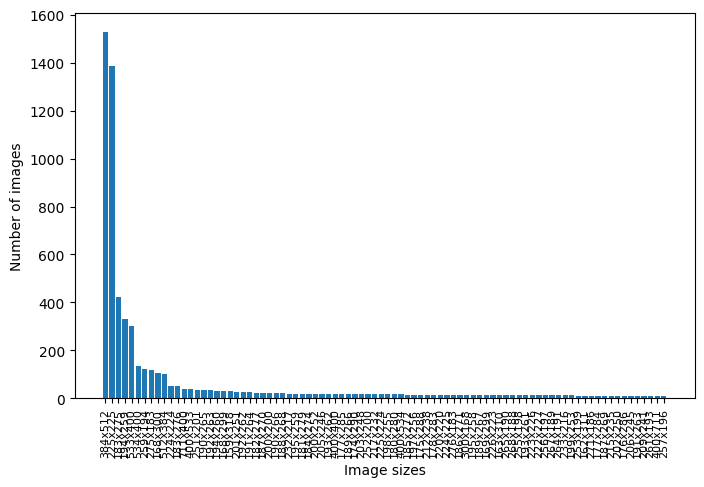

In [ ]:
plot_image_dimensions(training_path)

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 128
NUM_CLASSES = 8


In the chart above, we can see that the most popular image size in the dataset is 181x181. We therefore decided to set the IMAGE_WIDTH and IMAGE_HEIGHT variables with the most common values.

## Load dataset

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    training_path,
    label_mode='categorical',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_path,
    label_mode='categorical',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 7040 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.


# Utility methods

A function to define the callbacks_list and train the model.

In [ ]:
def compile_and_fit(model, model_name, model_path, learning_rate=None, optimizer='adam'):

  if not os.path.exists(model_path):
    os.makedirs(model_path)

  save_path = os.path.join(model_path, model_name + '.h5')

  if learning_rate is not None:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  
  callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=1e-3,
      patience=5,), 
    keras.callbacks.ModelCheckpoint(
      filepath = save_path,
      monitor="val_loss",
      verbose=1,
      save_best_only=True)]

  history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks_list)    
  plot_accuracy_loss(history)

A function to plot accuracy and loss, both for training set and validation set.

In [ ]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_loss_epoch = np.argmin(val_loss)
  best_loss = np.min(val_loss)
  best_acc = val_acc[best_loss_epoch]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'bo', label='Validation loss')
  plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

A function to evaluate the model against the test set.

In [ ]:
def eval (model):
  y_score = model.predict(test_dataset)
  model.evaluate(test_dataset)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(type(y_true))
  print(type(y_pred))
  print(y_pred.argmax(axis=1))
  print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))

  # ROC curve
  '''fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()'''

# CNN Implementation

In this section, we'll train the model using a standard CNN, gradually adding complexity to the network and comparing the results. To reduce overfitting, we'll also apply techniques such as normalization, data augmentation, and dropouts.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])

## Model 1: Standard CNN

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                         

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.7688 - accuracy: 0.3528
Epoch 1: val_loss improved from inf to 1.65270, saving model to /content/models/standardCNN/standardCNN.h5
55/55 [==============================] - 29s 277ms/step - loss: 1.7688 - accuracy: 0.3528 - val_loss: 1.6527 - val_accuracy: 0.4027
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.4270 - accuracy: 0.4825
Epoch 2: val_loss improved from 1.65270 to 1.32993, saving model to /content/models/standardCNN/standardCNN.h5
55/55 [==============================] - 16s 278ms/step - loss: 1.4270 - accuracy: 0.4825 - val_loss: 1.3299 - val_accuracy: 0.5423
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.3000 - accuracy: 0.5411
Epoch 3: val_loss improved from 1.32993 to 1.22223, saving model to /content/models/standardCNN/standardCNN.h5
55/55 [==============================] - 16s 269ms/step - loss: 1.3000 - accuracy: 0.5411 - val_loss: 1.2222 - val_accurac

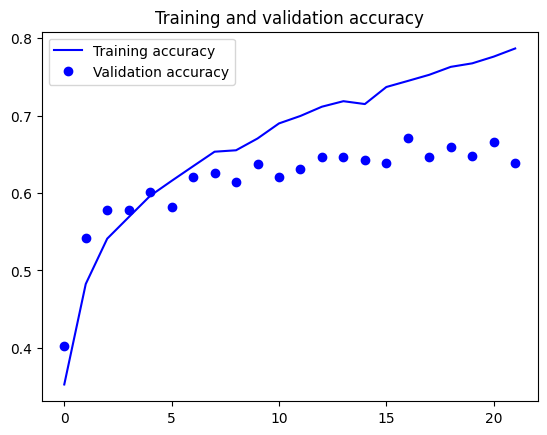

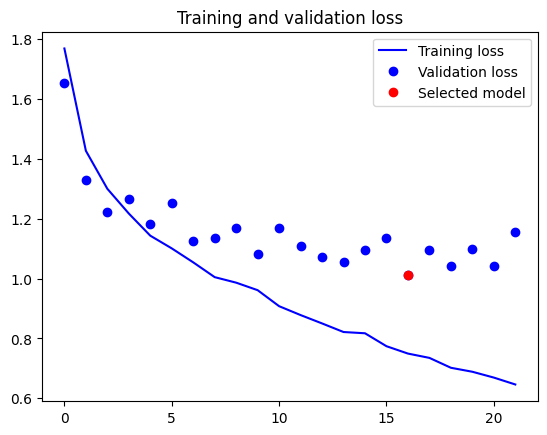

Lowest validation loss has been reached at epoch 16 with validation accuracy of 0.671


In [ ]:
model_name = "standardCNN"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

73/73 [==============================] - 3s 33ms/step - loss: 0.9302 - accuracy: 0.6830
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[1 1 1 ... 6 0 1]
              precision    recall  f1-score   support

           0     0.0379    0.2213    0.0647       122
           1     0.4434    0.3041    0.3608      1095
           2     0.1274    0.0891    0.1049       303
           3     0.0426    0.0161    0.0234       124
           4     0.0685    0.0667    0.0676       150
           5     0.1116    0.0808    0.0937       297
           6     0.0284    0.0331    0.0305       121
           7     0.0680    0.0603    0.0639       116

    accuracy                         0.1864      2328
   macro avg     0.1160    0.1089    0.1012      2328
weighted avg     0.2529    0.1864    0.2091      2328



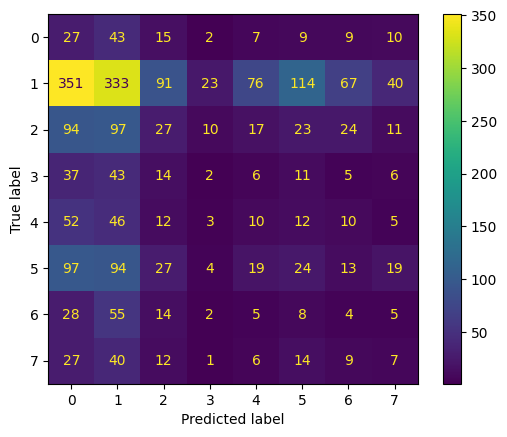

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Considerations

The model quickly begins to overfit, and after epoch 5, there are no improvements in validation loss. This is likely due to the model's simplicity, and we need to add more layers to increase its depth and improve its performance.

## Model 2: One dense layer and four Conv2D layers

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 181, 181, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 181, 181, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 181, 181, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                       

Epoch 1/100
219/220 [============================>.] - ETA: 0s - loss: 1.8707 - accuracy: 0.2743
Epoch 1: val_loss improved from inf to 1.58126, saving model to /content/modelli/OneDense4Conv2D/OneDense4Conv2D.h5
220/220 [==============================] - 16s 58ms/step - loss: 1.8699 - accuracy: 0.2749 - val_loss: 1.5813 - val_accuracy: 0.3924
Epoch 2/100
219/220 [============================>.] - ETA: 0s - loss: 1.4896 - accuracy: 0.4563
Epoch 2: val_loss improved from 1.58126 to 1.37503, saving model to /content/modelli/OneDense4Conv2D/OneDense4Conv2D.h5
220/220 [==============================] - 13s 58ms/step - loss: 1.4895 - accuracy: 0.4565 - val_loss: 1.3750 - val_accuracy: 0.4955
Epoch 3/100
218/220 [============================>.] - ETA: 0s - loss: 1.3641 - accuracy: 0.5034
Epoch 3: val_loss improved from 1.37503 to 1.32055, saving model to /content/modelli/OneDense4Conv2D/OneDense4Conv2D.h5
220/220 [==============================] - 13s 58ms/step - loss: 1.3627 - accuracy: 0.5

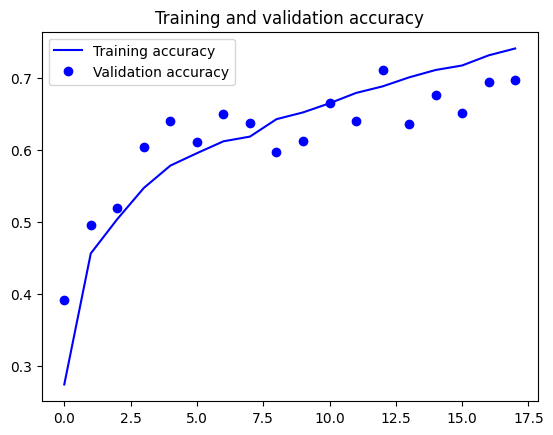

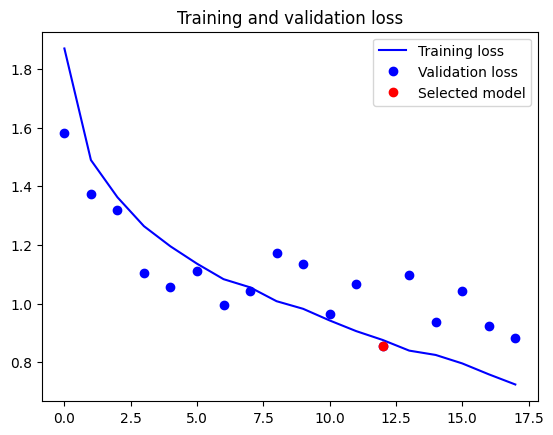

Lowest validation loss has been reached at epoch 12 with validation accuracy of 0.711


In [ ]:
model_name = "OneDense4Conv2D"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

73/73 [==============================] - 3s 34ms/step - loss: 0.8465 - accuracy: 0.6993
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[6 0 1 ... 0 0 5]
              precision    recall  f1-score   support

           0     0.0576    0.3279    0.0979       122
           1     0.4534    0.3507    0.3955      1095
           2     0.1187    0.0627    0.0821       303
           3     0.0588    0.0242    0.0343       124
           4     0.0482    0.0533    0.0506       150
           5     0.1381    0.0976    0.1144       297
           6     0.0769    0.0661    0.0711       121
           7     0.0842    0.0690    0.0758       116

    accuracy                         0.2143      2328
   macro avg     0.1295    0.1314    0.1152      2328
weighted avg     0.2638    0.2143    0.2290      2328



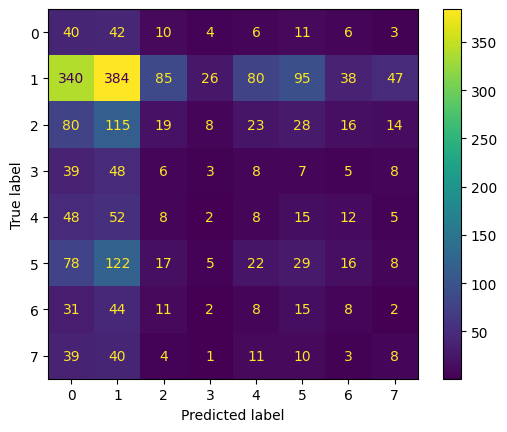

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Considerations

##Model 3: One Dropout and Dense layer

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 181, 181, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 181, 181, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 181, 181, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                       

Epoch 1/100
218/220 [============================>.] - ETA: 0s - loss: 1.8776 - accuracy: 0.2659
Epoch 1: val_loss improved from inf to 1.74144, saving model to /content/modelli/OneDropout64Dense/OneDropout64Dense.h5
220/220 [==============================] - 17s 62ms/step - loss: 1.8762 - accuracy: 0.2669 - val_loss: 1.7414 - val_accuracy: 0.3790
Epoch 2/100
218/220 [============================>.] - ETA: 0s - loss: 1.6643 - accuracy: 0.3691
Epoch 2: val_loss improved from 1.74144 to 1.65447, saving model to /content/modelli/OneDropout64Dense/OneDropout64Dense.h5
220/220 [==============================] - 12s 52ms/step - loss: 1.6629 - accuracy: 0.3689 - val_loss: 1.6545 - val_accuracy: 0.4349
Epoch 3/100
219/220 [============================>.] - ETA: 0s - loss: 1.5477 - accuracy: 0.4309
Epoch 3: val_loss improved from 1.65447 to 1.58949, saving model to /content/modelli/OneDropout64Dense/OneDropout64Dense.h5
220/220 [==============================] - 12s 51ms/step - loss: 1.5482 - a

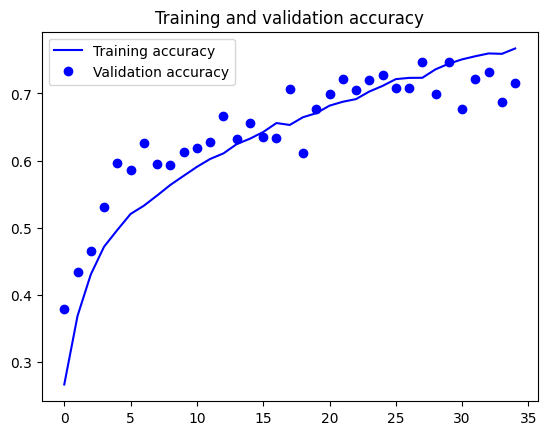

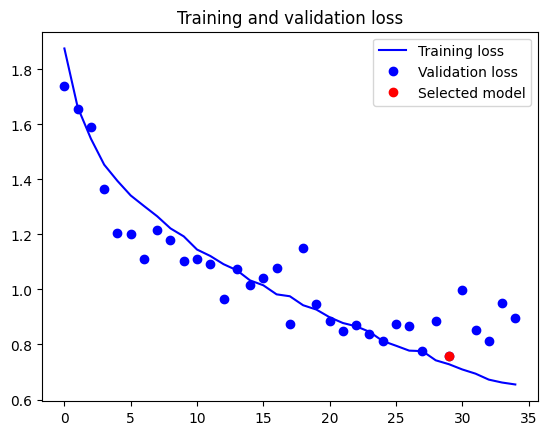

Lowest validation loss has been reached at epoch 29 with validation accuracy of 0.746


In [ ]:
model_name = "OneDropout64Dense"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

73/73 [==============================] - 3s 33ms/step - loss: 0.7263 - accuracy: 0.7457
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[4 4 4 ... 5 5 1]
              precision    recall  f1-score   support

           0     0.0604    0.2951    0.1003       122
           1     0.4574    0.3534    0.3988      1095
           2     0.1166    0.0627    0.0815       303
           3     0.0391    0.0403    0.0397       124
           4     0.0890    0.0867    0.0878       150
           5     0.1493    0.1347    0.1416       297
           6     0.0208    0.0165    0.0184       121
           7     0.0706    0.0517    0.0597       116

    accuracy                         0.2182      2328
   macro avg     0.1254    0.1301    0.1160      2328
weighted avg     0.2650    0.2182    0.2332      2328



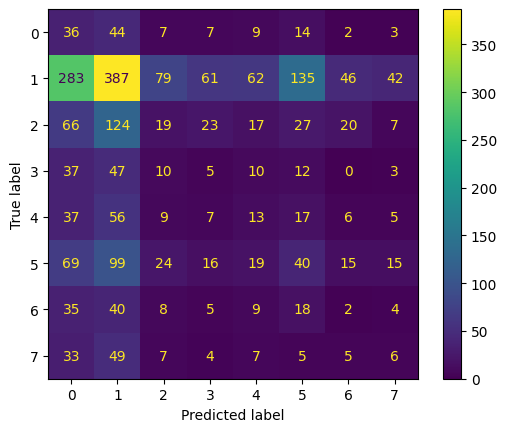

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Consideration

##Model 4: Two Dropout and Dense layer

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 181, 181, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 181, 181, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 181, 181, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                      

Epoch 1/100
218/220 [============================>.] - ETA: 0s - loss: 1.9281 - accuracy: 0.2397
Epoch 1: val_loss improved from inf to 1.80417, saving model to /content/modelli/TwoDropout128Dense/TwoDropout128Dense.h5
220/220 [==============================] - 15s 57ms/step - loss: 1.9259 - accuracy: 0.2411 - val_loss: 1.8042 - val_accuracy: 0.2686
Epoch 2/100
218/220 [============================>.] - ETA: 0s - loss: 1.6099 - accuracy: 0.3908
Epoch 2: val_loss improved from 1.80417 to 1.53183, saving model to /content/modelli/TwoDropout128Dense/TwoDropout128Dense.h5
220/220 [==============================] - 13s 57ms/step - loss: 1.6103 - accuracy: 0.3912 - val_loss: 1.5318 - val_accuracy: 0.4443
Epoch 3/100
218/220 [============================>.] - ETA: 0s - loss: 1.4370 - accuracy: 0.4695
Epoch 3: val_loss improved from 1.53183 to 1.35775, saving model to /content/modelli/TwoDropout128Dense/TwoDropout128Dense.h5
220/220 [==============================] - 13s 57ms/step - loss: 1.43

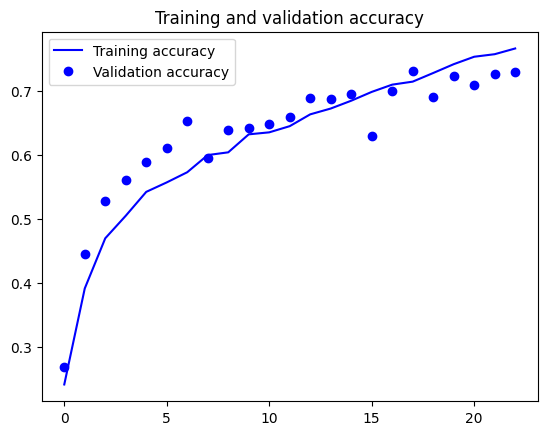

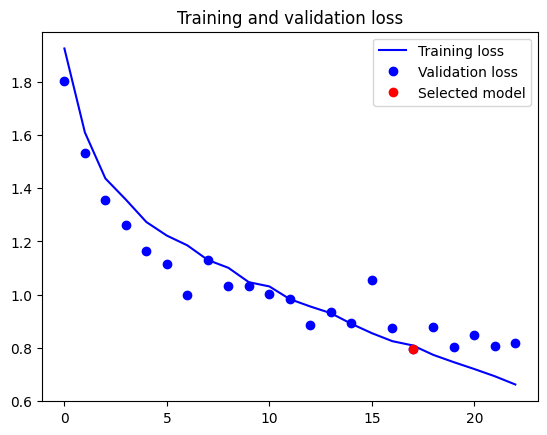

Lowest validation loss has been reached at epoch 17 with validation accuracy of 0.731


In [ ]:
model_name = "TwoDropout128Dense"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

73/73 [==============================] - 3s 33ms/step - loss: 0.8048 - accuracy: 0.7208
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[3 0 4 ... 4 0 0]
              precision    recall  f1-score   support

           0     0.0522    0.2869    0.0883       122
           1     0.4540    0.3288    0.3814      1095
           2     0.1528    0.0726    0.0984       303
           3     0.0488    0.0323    0.0388       124
           4     0.0636    0.0933    0.0757       150
           5     0.1244    0.0875    0.1028       297
           6     0.0538    0.0413    0.0467       121
           7     0.0172    0.0172    0.0172       116

    accuracy                         0.2010      2328
   macro avg     0.1208    0.1200    0.1062      2328
weighted avg     0.2624    0.2010    0.2202      2328



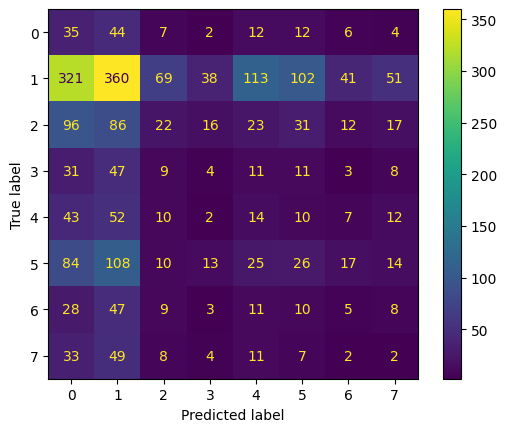

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Consideration

## Model 5: Normalization layer

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)

x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=4)(x)

x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 181, 181, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 181, 181, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 181, 181, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 181, 181, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 45, 45, 64)        1849

Epoch 1/100
220/220 [==============================] - ETA: 0s - loss: 1.5044 - accuracy: 0.5061
Epoch 1: val_loss improved from inf to 2.46492, saving model to /content/modelli/BatchNormalizationLayer/BatchNormalizationLayer.h5
220/220 [==============================] - 18s 59ms/step - loss: 1.5044 - accuracy: 0.5061 - val_loss: 2.4649 - val_accuracy: 0.2097
Epoch 2/100
219/220 [============================>.] - ETA: 0s - loss: 0.9933 - accuracy: 0.6523
Epoch 2: val_loss improved from 2.46492 to 1.07136, saving model to /content/modelli/BatchNormalizationLayer/BatchNormalizationLayer.h5
220/220 [==============================] - 14s 63ms/step - loss: 0.9926 - accuracy: 0.6526 - val_loss: 1.0714 - val_accuracy: 0.6356
Epoch 3/100
220/220 [==============================] - ETA: 0s - loss: 0.7696 - accuracy: 0.7320
Epoch 3: val_loss improved from 1.07136 to 0.97006, saving model to /content/modelli/BatchNormalizationLayer/BatchNormalizationLayer.h5
220/220 [==============================

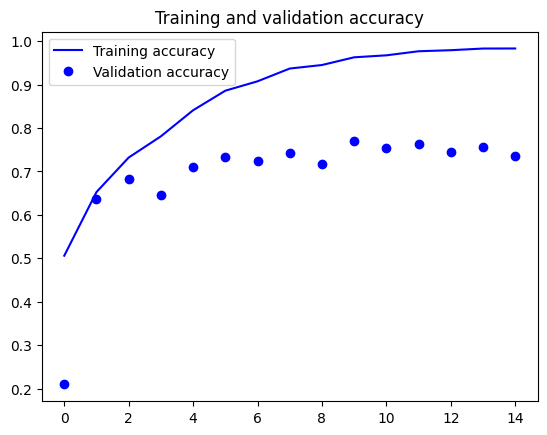

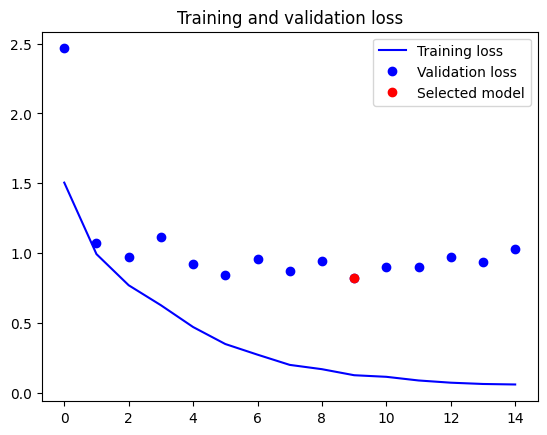

Lowest validation loss has been reached at epoch 9 with validation accuracy of 0.770


In [ ]:
model_name = "BatchNormalizationLayer"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

73/73 [==============================] - 4s 56ms/step - loss: 0.8091 - accuracy: 0.7668
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[1 1 1 ... 4 3 6]
              precision    recall  f1-score   support

           0     0.0647    0.1639    0.0928       122
           1     0.4634    0.4100    0.4351      1095
           2     0.1667    0.1320    0.1473       303
           3     0.0893    0.0806    0.0847       124
           4     0.0802    0.1133    0.0939       150
           5     0.1284    0.0943    0.1087       297
           6     0.0569    0.0579    0.0574       121
           7     0.0345    0.0431    0.0383       116

    accuracy                         0.2474      2328
   macro avg     0.1355    0.1369    0.1323      2328
weighted avg     0.2740    0.2474    0.2580      2328



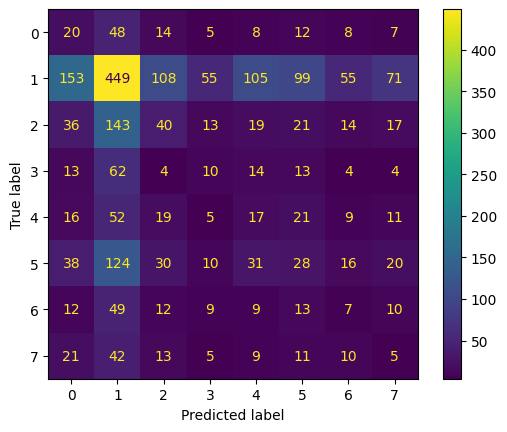

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Consideration

##Model 6: Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.2), # Rotates the input images by a random value in the range[–10%, +10%] (fraction of full circle [-36°, 36°])
  layers.RandomZoom(0.1), # Zooms in or out of the image by a random factor in the range [-20%, +20%]
])

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = data_augmentation(inputs)
x = resize_and_rescale(x)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 181, 181, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 181, 181, 3)       0         
                                                                 
 sequential (Sequential)     (None, 181, 181, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 181, 181, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 45, 45, 64)        18496     
                                                           

Epoch 1/100
218/220 [============================>.] - ETA: 0s - loss: 1.8311 - accuracy: 0.2944
Epoch 1: val_loss improved from inf to 1.67766, saving model to /content/modelli/DataAugmentationLayer/DataAugmentationLayer.h5
220/220 [==============================] - 16s 60ms/step - loss: 1.8300 - accuracy: 0.2955 - val_loss: 1.6777 - val_accuracy: 0.3949
Epoch 2/100
220/220 [==============================] - ETA: 0s - loss: 1.5428 - accuracy: 0.4313
Epoch 2: val_loss improved from 1.67766 to 1.37562, saving model to /content/modelli/DataAugmentationLayer/DataAugmentationLayer.h5
220/220 [==============================] - 13s 59ms/step - loss: 1.5428 - accuracy: 0.4313 - val_loss: 1.3756 - val_accuracy: 0.5312
Epoch 3/100
220/220 [==============================] - ETA: 0s - loss: 1.4283 - accuracy: 0.4838
Epoch 3: val_loss improved from 1.37562 to 1.21783, saving model to /content/modelli/DataAugmentationLayer/DataAugmentationLayer.h5
220/220 [==============================] - 13s 58ms

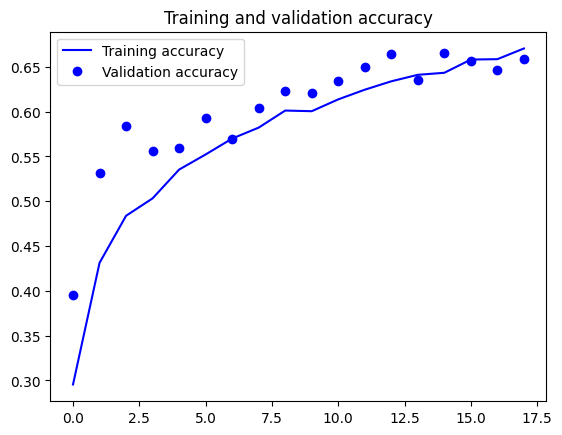

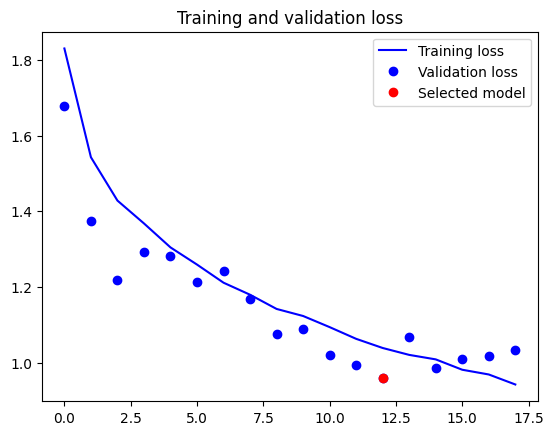

Lowest validation loss has been reached at epoch 12 with validation accuracy of 0.664


In [ ]:
model_name = "DataAugmentationLayer"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

73/73 [==============================] - 5s 58ms/step - loss: 0.9815 - accuracy: 0.6499
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[1 1 0 ... 4 3 0]
              precision    recall  f1-score   support

           0     0.0682    0.4426    0.1182       122
           1     0.4853    0.3306    0.3933      1095
           2     0.1083    0.0429    0.0615       303
           3     0.0309    0.0242    0.0271       124
           4     0.0759    0.0733    0.0746       150
           5     0.0976    0.0976    0.0976       297
           6     0.0682    0.0496    0.0574       121
           7     0.0465    0.0172    0.0252       116

    accuracy                         0.2062      2328
   macro avg     0.1226    0.1348    0.1069      2328
weighted avg     0.2708    0.2062    0.2221      2328



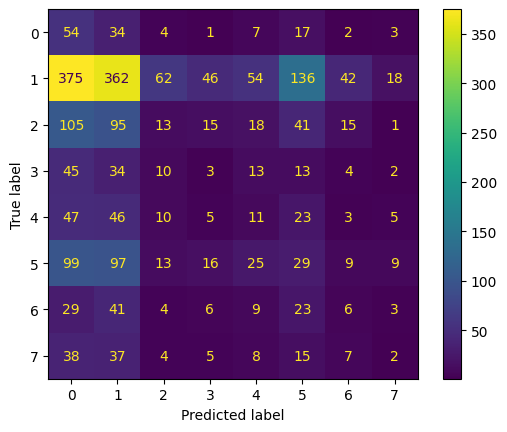

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Considerations

# Model 3: Hyperparameter tuning

## Setup

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 KB 12.6 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

my_dir = "/content/tuner"
if not os.path.exists(my_dir):
  os.makedirs(my_dir)
log_dir = my_dir + "/logs/" + datetime.datetime.now().strftime("%m%d-%H%M")

## Model builder

In [ ]:
def model_builder(hp):
  # Hyperparameter 
  activation_hp = hp.Choice('activation_function', values=['relu', 'elu', 'gelu'])
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  dropout_rate_hp = hp.Float('dropout_rate', min_value = 0, max_value = 0.5)

  inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
  x = resize_and_rescale(inputs)
  x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=4)(x)
  x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(hp_units)(x)
  x = layers.Dropout(dropout_rate_hp)(x)

  outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='oneDenseOneDropoutTuned')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perform hyperparameter tuning

In [ ]:
stop_early = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=20,
                     factor=3,
                     directory=log_dir,
                     project_name='model_tuned')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation_function (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'gelu'], 'ordered': False}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}


Perforom search for the best hyperparameters. 

In [ ]:
tuner.search(train_dataset, epochs=20, validation_data=validation_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. \
        The optimal number of units in the first densely-connected layer is {best_hps.get('units')} and \
        the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

Trial 6 Complete [00h 01m 01s]
val_accuracy: 0.5625268816947937

Best val_accuracy So Far: 0.6635152697563171
Total elapsed time: 00h 05m 45s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
gelu              |relu              |activation_function
480               |96                |units
0.001             |0.001             |learning_rate
0.36999           |0.13283           |dropout_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
  6/220 [..............................] - ETA: 12s - loss: 2.0987 - accuracy: 0.1875

203/220 [==========================>...] - ETA: 1s - loss: 1.5420 - accuracy: 0.4364

KeyboardInterrupt: ignored

In [ ]:
tuner.results_summary()

## Train model with the best hyperparameters

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=stop_early)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset, callbacks=stop_early)

In [ ]:
eval_result = hypermodel.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

# Model 4: Hyperparameter tuning

## Model builder

In [ ]:
def model_builder(hp):
  # Hyperparameter 
  activation_hp = hp.Choice('activation_function', values=['relu', 'elu', 'gelu'])
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  dropout_rate_hp1 = hp.Float('dropout_rate1', min_value = 0, max_value = 0.5)
  dropout_rate_hp2 = hp.Float('dropout_rate2', min_value = 0, max_value = 0.5)

  inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
  x = resize_and_rescale(inputs)
  x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=4)(x)
  x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(dropout_rate_hp1)(x)
  x = layers.Dense(hp_units1)(x)
  x = layers.Dense(hp_units2)(x)
  x = layers.Dropout(dropout_rate_hp2)(x)

  outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='oneDenseOneDropoutTuned')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perform hyperparameter tuning

In [ ]:
stop_early = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=20,
                     factor=3,
                     directory=log_dir,
                     project_name='model_tuned')

In [ ]:
tuner.search_space_summary()

Perforom search for the best hyperparameters. 

In [ ]:
tuner.search(train_dataset, epochs=20, validation_data=validation_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. \
        The optimal number of units in the first densely-connected layer is {best_hps.get('units1')}, \n
        The optimal number of units in the second densely-connected layer is {best_hps.get('units2')}, \n
        The optimal dropout value's for the first dropout layer is {best_hps.get('dropout_rate1')}, \n
        The optimal dropout value's for the second dropout layer is {best_hps.get('dropout_rate2')}, \n
        the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

In [ ]:
tuner.results_summary()

## Train model with the best hyperparameters

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset)

In [ ]:
eval_result = hypermodel.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)